# Cartpole simulation
![Cartpole diagram taken from Reference [1] ](../docs/cartpole.svg "Cart pole")

## Equation of motion
![Cartpole Equations of motion](../docs/cartpole_eom.png "Cart pole")

## References
1. [Underactuated Robotics: Chapter 3 Acrobots, Cart-Poles, and Quadrotors](https://underactuated.csail.mit.edu/acrobot.html)

# Simulator

number of states nx = 4
cc -fPIC -std=c99   -O2 -I/home/john/repos/acados/include -I/home/john/repos/acados/include/acados -I/home/john/repos/acados/include/blasfeo/include -I/home/john/repos/acados/include/hpipm/include  -c -o acados_sim_solver_pendulum_ode.o acados_sim_solver_pendulum_ode.c
cc -fPIC -std=c99   -O2 -I/home/john/repos/acados/include -I/home/john/repos/acados/include/acados -I/home/john/repos/acados/include/blasfeo/include -I/home/john/repos/acados/include/hpipm/include  -c -o pendulum_ode_model/pendulum_ode_impl_dae_fun.o pendulum_ode_model/pendulum_ode_impl_dae_fun.c
cc -fPIC -std=c99   -O2 -I/home/john/repos/acados/include -I/home/john/repos/acados/include/acados -I/home/john/repos/acados/include/blasfeo/include -I/home/john/repos/acados/include/hpipm/include  -c -o pendulum_ode_model/pendulum_ode_impl_dae_fun_jac_x_xdot_z.o pendulum_ode_model/pendulum_ode_impl_dae_fun_jac_x_xdot_z.c
cc -fPIC -std=c99   -O2 -I/home/john/repos/acados/include -I/home/john/repos/acados/

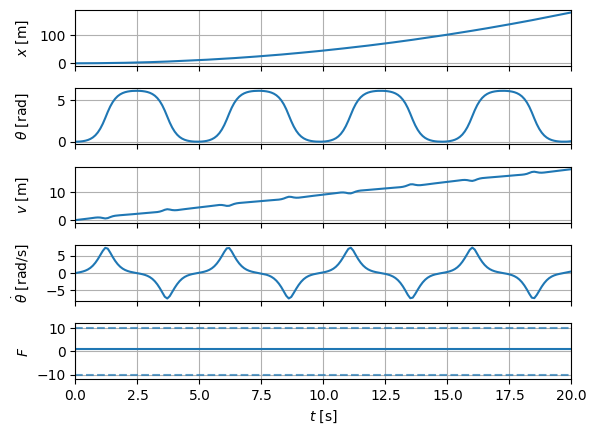

In [2]:
from acados_template import AcadosSim, AcadosSimSolver
from pendulum_model import export_pendulum_ode_model
from utils import plot_pendulum
import numpy as np

sim = AcadosSim()
sim.model = export_pendulum_ode_model()

Tf = 0.1 # Time horizon
nx = sim.model.x.rows() # Number of states
print(f"number of states nx = {nx}")
N_sim = 200

# set simulation time
sim.solver_options.T = Tf
# set options
sim.solver_options.integrator_type = 'IRK'
sim.solver_options.num_stages = 3
sim.solver_options.num_steps = 3
sim.solver_options.newton_iter = 3 # for implicit integrator
sim.solver_options.collocation_type = "GAUSS_RADAU_IIA"

# create simulation solver
acados_integrator = AcadosSimSolver(sim)

x0 = np.array([0.0, 0.0, 0.0, 0.0]) # Initial state (x_dot, theta_dot)
u0 = np.array([1.0])                    # Initial control input

xdot_init = np.array([0.0, 0.0, 0.0, 0.0]) # Initial speed
    # x1_dot
    # theta_dot
    # v1_dot
    # dtheta_dot
# xdot_init = np.zeros((nx,))             # Initial speed

simX = np.zeros((N_sim+1, nx))          
simX[0,:] = x0

for i in range(N_sim):
    # Note that xdot is only used if an IRK integrator is used
    simX[i+1,:] = acados_integrator.simulate(x=simX[i,:], u=u0, xdot=xdot_init)

S_forw = acados_integrator.get("S_forw")
print("S_forw, sensitivities of simulation result wrt x,u:\n", S_forw)

t = np.linspace(0, N_sim*Tf, N_sim+1) # Time array

print(f"t: {t.shape}")
print(f"np.repeat(u0, N_sim): {(np.repeat(u0, N_sim)).shape}")

plot_pendulum(t, 10, np.repeat(u0, N_sim), simX,
                latexify=False, time_label=sim.model.t_label, x_labels=sim.model.x_labels, u_labels=sim.model.u_labels)



# Open loop OCP

In [ ]:
from acados_template import AcadosOcp, AcadosOcpSolver
from pendulum_model import export_pendulum_ode_model
import numpy as np
import casadi as ca
from utils import plot_pendulum

ocp = AcadosOcp()

model = export_pendulum_ode_model()
ocp.model = model

Tf = 4.0 # Prediction horizon
nx = model.x.rows() # Number of state variables
nu = model.u.rows() # Number of control variables
N = 20

# Set number of shooting intervals
ocp.dims.N = N
# Set prediction horizon
ocp.solver_options.tf = Tf

# Cost matrices
Q_mat = 2 * np.diag([1e3, 1e3, 1e-2, 1e-2])
R_mat = 2 * np.diag([1e-2])

# Path cost
ocp.cost.cost_type = "NONLINEAR_LS" # EXTERNAL, LINEAR_LS, NONLINEAR_LS, CONVEX_OVER_NONLINEAR
ocp.model.cost_y_expr = ca.vertcat(model.x, model.u) #CasADi expression for nonlinear least squares
ocp.cost.yref = np.zeros((nx+nu,)) #  reference at intermediate shooting nodes (1 to N-1).
ocp.cost.W = ca.diagcat(Q_mat, R_mat).full()

# Terminal cost
ocp.cost.cost_type_e = "NONLINEAR_LS"
ocp.cost.yref_e = np.zeros((nx,)) # cost reference at terminal shooting node (N).
ocp.model.cost_y_expr_e = model.x
ocp.cost.W_e = Q_mat

# Set constraints
Fmax = 80
ocp.constraints.lbu = np.array([-Fmax]) # Lower bound on controls
ocp.constraints.ubu = np.array([+Fmax]) # Upper bound on controls
ocp.constraints.idxbu = np.array([0]) #Indices of bounds on u (defines Jbu) at shooting nodes (0 to N-1). Can be set by using Jbu

ocp.constraints.x0 = np.array([0.0, np.pi, 0.0, 0.0])

# set options
ocp.solver_options.qp_solver = 'PARTIAL_CONDENSING_HPIPM' # FULL_CONDENSING_QPOASES
# PARTIAL_CONDENSING_HPIPM, FULL_CONDENSING_QPOASES, FULL_CONDENSING_HPIPM,
# PARTIAL_CONDENSING_QPDUNES, PARTIAL_CONDENSING_OSQP, FULL_CONDENSING_DAQP
ocp.solver_options.hessian_approx = 'GAUSS_NEWTON' # 'GAUSS_NEWTON', 'EXACT'
ocp.solver_options.integrator_type = 'IRK'
# ocp.solver_options.print_level = 1
ocp.solver_options.nlp_solver_type = 'SQP' # SQP_RTI, SQP
ocp.solver_options.globalization = 'MERIT_BACKTRACKING' # turns on globalization

ocp_solver = AcadosOcpSolver(ocp)

simX = np.zeros((N+1, nx))
simU = np.zeros((N, nu))

status = ocp_solver.solve()
ocp_solver.print_statistics() # encapsulates: stat = ocp_solver.get_stats("statistics")

if status != 0:
    raise Exception(f'acados returned status {status}.')

# Get solution
for i in range(N):
    simX[i,:] = ocp_solver.get(i, "x")
    simU[i,:] = ocp_solver.get(i, "u")
simX[N,:] = ocp_solver.get(N, "x")

print(f"simX[0,:]: {simX[0,:]}")
print(f"simX[N,:]: {simX[N,:]}")

plot_pendulum(np.linspace(0, Tf, N+1), Fmax, simU, simX, latexify=True, time_label=model.t_label, x_labels=model.x_labels, u_labels=model.u_labels)


: 

# Closed loop OCP

rm -f libacados_ocp_solver_pendulum_ode.so
rm -f pendulum_ode_cost/pendulum_ode_cost_y_0_fun.o pendulum_ode_cost/pendulum_ode_cost_y_0_fun_jac_ut_xt.o pendulum_ode_cost/pendulum_ode_cost_y_0_hess.o pendulum_ode_cost/pendulum_ode_cost_y_fun.o pendulum_ode_cost/pendulum_ode_cost_y_fun_jac_ut_xt.o pendulum_ode_cost/pendulum_ode_cost_y_hess.o pendulum_ode_cost/pendulum_ode_cost_y_e_fun.o pendulum_ode_cost/pendulum_ode_cost_y_e_fun_jac_ut_xt.o pendulum_ode_cost/pendulum_ode_cost_y_e_hess.o acados_solver_pendulum_ode.o
cc -fPIC -std=c99   -O2 -I/home/john/acados/include -I/home/john/acados/include/acados -I/home/john/acados/include/blasfeo/include -I/home/john/acados/include/hpipm/include  -c -o pendulum_ode_cost/pendulum_ode_cost_y_0_fun.o pendulum_ode_cost/pendulum_ode_cost_y_0_fun.c
cc -fPIC -std=c99   -O2 -I/home/john/acados/include -I/home/john/acados/include/acados -I/home/john/acados/include/blasfeo/include -I/home/john/acados/include/hpipm/include  -c -o pendulum_ode_cost/pendulum_od

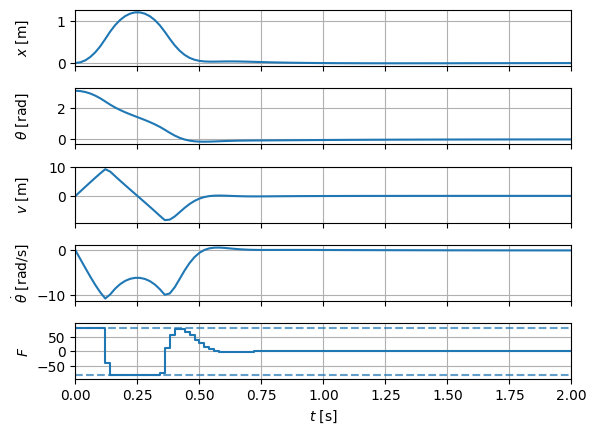

In [3]:
# Taken from ACADOS examples, copyright excluded for brevity

from acados_template import AcadosOcp, AcadosOcpSolver, AcadosSimSolver
from pendulum_model import export_pendulum_ode_model
from utils import plot_pendulum
import numpy as np
import scipy.linalg
import casadi as ca
from casadi import vertcat

def setup(x0, Fmax, N_horizon, Tf, RTI=False):
    # create ocp object to formulate the OCP
    ocp = AcadosOcp()

    # set model
    model = export_pendulum_ode_model()
    ocp.model = model

    nx = model.x.rows()
    nu = model.u.rows()
    ny = nx + nu
    ny_e = nx

    ocp.dims.N = N_horizon # Set number of shooting intervals

    # Cost matrices
    Q_mat = 2 * np.diag([1e3, 1e3, 1e-2, 1e-2])
    R_mat = 2 * np.diag([1e-2])

    # Path cost
    ocp.cost.cost_type = "NONLINEAR_LS"
    ocp.model.cost_y_expr = ca.vertcat(model.x, model.u) #CasADi expression for nonlinear least squares
    ocp.cost.yref = np.zeros((ny,)) #  reference at intermediate shooting nodes (1 to N-1).
    ocp.cost.W = ca.diagcat(Q_mat, R_mat).full()

    # Terminal cost
    ocp.cost.cost_type_e = "NONLINEAR_LS"
    ocp.cost.yref_e = np.zeros((ny_e,)) # cost reference at terminal shooting node (N).
    ocp.model.cost_y_expr_e = model.x
    ocp.cost.W_e = Q_mat

    # Set constraints
    Fmax = 80
    ocp.constraints.lbu = np.array([-Fmax]) # Lower bound on controls
    ocp.constraints.ubu = np.array([+Fmax]) # Upper bound on controls

    ocp.constraints.x0 = x0
    ocp.constraints.idxbu = np.array([0]) #Indices of bounds on u (defines Jbu) at shooting nodes (0 to N-1). Can be set by using Jbu

    ocp.solver_options.qp_solver = 'PARTIAL_CONDENSING_HPIPM' # FULL_CONDENSING_QPOASES
    ocp.solver_options.hessian_approx = 'GAUSS_NEWTON'
    ocp.solver_options.integrator_type = 'IRK'
    ocp.solver_options.sim_method_newton_iter = 10

    if RTI:
        ocp.solver_options.nlp_solver_type = 'SQP_RTI'
    else:
        ocp.solver_options.nlp_solver_type = 'SQP'
        ocp.solver_options.globalization = 'MERIT_BACKTRACKING' # turns on globalization
        ocp.solver_options.nlp_solver_max_iter = 150

    ocp.solver_options.qp_solver_cond_N = N_horizon

    # Set prediction horizon
    ocp.solver_options.tf = Tf

    solver_json = 'acados_ocp_' + model.name + '.json'
    acados_ocp_solver = AcadosOcpSolver(ocp, json_file = solver_json)

    # create an integrator with the same settings as used in the OCP solver.
    acados_integrator = AcadosSimSolver(ocp, json_file = solver_json)

    return acados_ocp_solver, acados_integrator

# Settings
x0 = np.array([0.0, np.pi, 0.0, 0.0])
Fmax = 80

Tf = .8
N_horizon = 40

use_RTI = False

# Solver 

ocp_solver, integrator = setup(x0, Fmax, N_horizon, Tf, use_RTI)

nx = ocp_solver.acados_ocp.dims.nx
nu = ocp_solver.acados_ocp.dims.nu

Nsim = 100
simX = np.zeros((Nsim+1, nx))   # Simulated states
simU = np.zeros((Nsim, nu))     # Simulated input

simX[0,:] = x0

if use_RTI:
    t_preparation = np.zeros((Nsim))
    t_feedback = np.zeros((Nsim))

else:
    t = np.zeros((Nsim))

# do some initial iterations to start with a good initial guess
num_iter_initial = 5
for _ in range(num_iter_initial):
    ocp_solver.solve_for_x0(x0_bar = x0)


# Closed loop
for i in range(Nsim):   # For each simulation step
    if use_RTI:
        ocp_solver.options_set('rti_phase', 1)
        status = ocp_solver.solve()
        t_preparation[i] = ocp_solver.get_stats('time_tot')

        # set initial state
        ocp_solver.set(0, "lbx", simX[i, :])
        ocp_solver.set(0, "ubx", simX[i, :])

        # feedback phase
        ocp_solver.options_set('rti_phase', 2)
        status = ocp_solver.solve()
        t_feedback[i] = ocp_solver.get_stats('time_tot')

        simU[i, :] = ocp_solver.get(0, "u")

    else:
        # Solve OCP and get control input u0
        simU[i, :] = ocp_solver.solve_for_x0(x0_bar = simX[i, :])

        t[i] = ocp_solver.get_stats('time_tot')

    # Simulate system with current state and current control input
    simX[i+1, :] = integrator.simulate(x=simX[i,:], u=simU[i,:])

# evaluate timings
if use_RTI:
    # scale to milliseconds
    t_preparation *= 1000
    t_feedback *= 1000
    print(f'Computation time in preparation phase in ms: \
            min {np.min(t_preparation):.3f} median {np.median(t_preparation):.3f} max {np.max(t_preparation):.3f}')
    print(f'Computation time in feedback phase in ms:    \
            min {np.min(t_feedback):.3f} median {np.median(t_feedback):.3f} max {np.max(t_feedback):.3f}')
else:
    # scale to milliseconds
    t *= 1000
    print(f'Computation time in ms: min {np.min(t):.3f} median {np.median(t):.3f} max {np.max(t):.3f}')


# plot results
model = ocp_solver.acados_ocp.model
plot_pendulum(np.linspace(0, (Tf/N_horizon)*Nsim, Nsim+1), Fmax, simU, simX, latexify=False, time_label=model.t_label, x_labels=model.x_labels, u_labels=model.u_labels)

ocp_solver = None